In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install evaluate


## Data analysis

In [ ]:
train_data = pd.read_csv("train.csv", index_col=0)
train_data = train_data.rename(columns={"label": "labels"})
train_data['text'] = train_data['text'].astype(str)
train_data['labels'] = train_data['labels'].astype(int)
train_data['src'] = train_data['src'].astype(str)

train_data = train_data.sample(100000, random_state=42)

train_data.sample(3)

,text,src,labels
ID,,,
21238,"Ткань отвратительная, сбоку дырка",rureviews,0
24993,"всё вроде бы нормально,упаковка целая,всего ли...",rureviews,0
160613,"Играли в открытую игру (я, муж и ребенок 11 ле...",geo,1


In [ ]:
train_data['text'].duplicated().sum()

np.int64(8)

In [ ]:
train_data['labels'].value_counts()

,count
labels,
1,33390
0,33309
2,33301


/tmp/ipython-input-2336518116.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tokens_count)


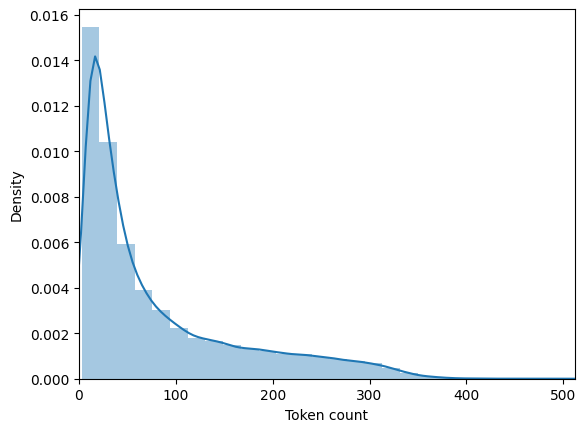

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokens_count = [len(s) for s in tokenizer(train_data["text"].tolist(), add_special_tokens=True)["input_ids"]]


sns.distplot(tokens_count)
plt.xlim([0, 512]);
plt.xlabel('Token count');

## Data cleaning

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest
from transformers import pipeline
import numpy as np
from tqdm import tqdm


def clean_data(train):
  model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

  batch_size = 512
  emb_size = model.get_sentence_embedding_dimension()

  X = np.memmap("embeddings.dat", dtype="float32", mode="w+", shape=(len(train), emb_size))

  for i in tqdm(range(0, len(train), batch_size)):
      batch = train["text"].iloc[i:i+batch_size].tolist()
      emb = model.encode(batch)

      X[i:i+batch_size] = emb

  clf = IsolationForest(contamination=0.02, random_state=42)
  outliers = clf.fit_predict(X)


  return train[(outliers == 1)].reset_index(drop=True)

In [ ]:
from datasets import Dataset
from transformers import BertForSequenceClassification
from transformers import DataCollatorWithPadding
import re
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

def clean_text(text):
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[\n\r\t]+", " ", text)
    text = re.sub(r"[\x00-\x1F\x7F]+", " ", text)
    text = re.sub(r"([^\w\s])\1{2,}", r"\1\1", text)
    text = re.sub(r"[^\w\s.,!?:;\"'()\-…/]+", " ", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    text = re.sub(r"\s*n\s*", " ", text)

    return text

train_data['text'] = train_data['text'].apply(clean_text)

train_data.dropna(subset=["text", "labels"], inplace=True)

# label_list = ['Нейтральный', 'Положительный', 'Отрицательный']
label_list = ['0', '1', '2']
label_to_index = {label: i for i, label in enumerate(label_list)}
index_to_label = {i: label for i, label in enumerate(label_list)}

train_data["labels"] = train_data["labels"].astype(int)

train, test = train_test_split(train_data, test_size=0.2, random_state=42)

print(train.shape)
train = clean_data(train)
print(train.shape)

train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)

def preprocess(examples, head=100, tail=100):
    ids = tokenizer(examples["text"], add_special_tokens=False)["input_ids"]

    if len(ids) > 210:
        head_tokens = ids[:head]
        tail_tokens = ids[-tail:]
        mid_token = tokenizer.sep_token_id
        new_ids = head_tokens + [mid_token] + tail_tokens
    else:
        new_ids = ids

    encoded = tokenizer.prepare_for_model(
        new_ids,
        truncation=True,
        padding='max_length',
        max_length=300,
    )

    return encoded

tokenized_train = train_ds.map(preprocess, batched=False)
tokenized_test = test_ds.map(preprocess, batched=False)

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
test_loader = DataLoader(tokenized_test, batch_size=32, shuffle=False, collate_fn=data_collator)

(80000, 3)


100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


(78400, 3)


Map:   0%|          | 0/78400 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

## Model training

In [ ]:
def save_model(model):
  output_dir = "./bert_sentiment_model"
  model.save_pretrained('model')
  tokenizer.save_pretrained('tokenizer')

  print(f"Model and tokenizer saved to {output_dir}")


def save_metr(new_metric_entry):
  path = "metrics.json"

  # если файл уже есть — загружаем список
  metrics_list = []
  if os.path.exists(path):
      with open(path, "r", encoding="utf-8") as f:
          metrics_list = json.load(f)
  else:
      metrics_list = []

  # добавляем новую запись
  metrics_list.append(new_metric_entry)

  # сохраняем обратно
  with open(path, "w", encoding="utf-8") as f:
      json.dump(metrics_list, f, ensure_ascii=False, indent=4)

In [ ]:
Global_Accuracy = 0

In [ ]:
from torch.nn.functional import softmax

def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    labels_predictions = []   # предсказанные классы
    pred_probs = []           # вероятность предсказанного класса
    labels_probs = []         # вероятность истинного класса

    for batch in tqdm(data_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

        loss = outputs.loss
        logits = outputs.logits  # [batch_size, num_labels]

        probs = softmax(logits, dim=-1)  # [batch, num_labels]

        predictions = torch.argmax(logits, dim=-1)

        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())


        labels_predictions.extend(predictions.cpu().tolist())

        batch_pred_probs = probs[torch.arange(len(predictions)), predictions]
        pred_probs.extend(batch_pred_probs.cpu().tolist())

        batch_label_probs = probs[torch.arange(len(labels)), labels]
        labels_probs.extend(batch_label_probs.cpu().tolist())

    avg_loss = total_loss / len(data_loader)

    accuracy_result = accuracy_metric.compute(
        predictions=all_predictions,
        references=all_labels
    )

    f1_micro = f1_metric.compute(
      predictions=all_predictions,
      references=all_labels,
      average="micro"
    )

    f1_macro = f1_metric.compute(
      predictions=all_predictions,
      references=all_labels,
      average="macro"
    )


    model.train()
    return avg_loss, accuracy_result["accuracy"], f1_micro, f1_macro, labels_predictions, pred_probs, labels_probs

def train_model(model, optimizer, train_loader, criterion, iteration, device):
    global Global_Accuracy
    model.train()

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch+1}/{epochs} ---")
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None
            )

            logits = outputs.logits
            loss = criterion(logits, labels)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            if (i + 1) % 100 == 0:
                print(f"Batch {i+1} Loss: {loss.item():.4f}")

        avg_val_loss, val_accuracy, f1_micro, f1_macro, _, _, _ = evaluate_model(model, test_loader, device)

        dic = {}
        dic['Accuracy'] = val_accuracy
        dic['F1_micro'] = f1_micro
        dic['F1_macro'] = f1_macro
        dic['Loss'] = 'CrossEntropy'
        dic['Epoch'] = epoch
        dic['Iteration'] = iteration
        dic['Model'] = 'Bert'
        save_metr(dic)

        if val_accuracy > Global_Accuracy:
            Global_Accuracy = val_accuracy
            save_model(model)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


In [ ]:
from transformers import  get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.optim import AdamW
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased-sentence",
     num_labels=len(label_list),
    id2label=index_to_label,
    label2id=label_to_index
)

model.to(device)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)

epochs = 3

optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_loader) * epochs
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model, optimizer, train_loader, criterion, 1, device)



--- Epoch 1/3 ---


  4%|▍         | 100/2450 [02:45<1:25:08,  2.17s/it]

Batch 100 Loss: 0.9130


  8%|▊         | 200/2450 [05:33<1:21:41,  2.18s/it]

Batch 200 Loss: 0.8266


 12%|█▏        | 300/2450 [08:22<1:17:53,  2.17s/it]

Batch 300 Loss: 0.8252


 16%|█▋        | 400/2450 [11:11<1:14:22,  2.18s/it]

Batch 400 Loss: 0.7385


 20%|██        | 500/2450 [13:59<1:10:45,  2.18s/it]

Batch 500 Loss: 0.7652


 22%|██▏       | 538/2450 [15:02<53:49,  1.69s/it]

In [ ]:
from datasets import Dataset
import evaluate

accuracy = evaluate.load("accuracy")

train_eval_loader = DataLoader(tokenized_train, batch_size=32, shuffle=False, collate_fn=data_collator)

av_loss, accuracy_score, f1_micro, f1_macro,  preds, preds_probs, label_probs = evaluate_model(model, train_eval_loader, device)

train["preds"] = preds
train["preds_probs"] = preds_probs
train['label_probs'] = label_probs

In [ ]:
print(f'before removing noisy labels shape: {train.shape}')
mask = (train['labels'] != train['preds']) & (train['label_probs'] < 0.3)
train = train[~mask]
print(f'after removing noisy labels shape: {train.shape}')

In [ ]:
# def change_labels(row):
#   if row['labels'] != row['preds'] and row['preds_probs'] > 0.9:
#     return row['preds']
#   else:
#     return row['labels']

# train['labels'] = train.apply(change_labels, axis=1) # Added axis=1 for row-wise application

In [ ]:
# Заново обучаем


train_ds = Dataset.from_pandas(train)
tokenized_train = train_ds.map(preprocess, batched=False)
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True, collate_fn=data_collator)


accuracy = evaluate.load("accuracy")

model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased-sentence",
     num_labels=len(label_list),
    id2label=index_to_label,
    label2id=label_to_index
)

model.to(device)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

epochs = 2

optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_loader) * epochs
)


Map:   0%|          | 0/57510 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model, optimizer, train_loader, criterion, 2, device)


--- Epoch 1/2 ---


  3%|▎         | 100/3595 [01:30<1:07:07,  1.15s/it]

Batch 100 Loss: 0.8825


  6%|▌         | 200/3595 [03:00<1:05:15,  1.15s/it]

Batch 200 Loss: 0.8966


  8%|▊         | 300/3595 [04:31<1:03:54,  1.16s/it]

Batch 300 Loss: 0.8035


 11%|█         | 400/3595 [06:01<1:01:46,  1.16s/it]

Batch 400 Loss: 0.6498


 14%|█▍        | 500/3595 [07:31<59:49,  1.16s/it]

Batch 500 Loss: 0.7298


 17%|█▋        | 600/3595 [09:01<57:40,  1.16s/it]

Batch 600 Loss: 0.6026


 19%|█▉        | 700/3595 [10:31<56:03,  1.16s/it]

Batch 700 Loss: 0.7456


 22%|██▏       | 800/3595 [12:01<54:08,  1.16s/it]

Batch 800 Loss: 0.7473


 25%|██▌       | 900/3595 [13:31<51:59,  1.16s/it]

Batch 900 Loss: 0.6270


 28%|██▊       | 1000/3595 [15:01<49:52,  1.15s/it]

Batch 1000 Loss: 0.6962


 31%|███       | 1100/3595 [16:31<48:10,  1.16s/it]

Batch 1100 Loss: 0.6026


 33%|███▎      | 1200/3595 [18:01<46:12,  1.16s/it]

Batch 1200 Loss: 0.4733


 36%|███▌      | 1300/3595 [19:31<44:26,  1.16s/it]

Batch 1300 Loss: 0.4973


 39%|███▉      | 1400/3595 [21:01<42:29,  1.16s/it]

Batch 1400 Loss: 0.5166


 42%|████▏     | 1500/3595 [22:31<40:32,  1.16s/it]

Batch 1500 Loss: 0.6765


 45%|████▍     | 1600/3595 [24:01<38:26,  1.16s/it]

Batch 1600 Loss: 0.4322


 47%|████▋     | 1700/3595 [25:31<36:41,  1.16s/it]

Batch 1700 Loss: 0.6986


 50%|█████     | 1800/3595 [27:01<34:38,  1.16s/it]

Batch 1800 Loss: 0.6940


 53%|█████▎    | 1900/3595 [28:31<32:42,  1.16s/it]

Batch 1900 Loss: 0.7250


 56%|█████▌    | 2000/3595 [30:01<30:46,  1.16s/it]

Batch 2000 Loss: 0.4609


 58%|█████▊    | 2100/3595 [31:31<28:51,  1.16s/it]

Batch 2100 Loss: 0.7567


 61%|██████    | 2200/3595 [33:01<26:59,  1.16s/it]

Batch 2200 Loss: 0.5800


 64%|██████▍   | 2300/3595 [34:32<25:05,  1.16s/it]

Batch 2300 Loss: 0.5640


 67%|██████▋   | 2400/3595 [36:02<22:59,  1.15s/it]

Batch 2400 Loss: 0.8116


 70%|██████▉   | 2500/3595 [37:32<21:05,  1.16s/it]

Batch 2500 Loss: 0.4026


 72%|███████▏  | 2600/3595 [39:02<19:14,  1.16s/it]

Batch 2600 Loss: 0.5490


 75%|███████▌  | 2700/3595 [40:31<17:13,  1.15s/it]

Batch 2700 Loss: 0.5225


 78%|███████▊  | 2800/3595 [42:01<15:18,  1.16s/it]

Batch 2800 Loss: 0.6260


 81%|████████  | 2900/3595 [43:32<13:24,  1.16s/it]

Batch 2900 Loss: 0.4495


 83%|████████▎ | 3000/3595 [45:02<11:32,  1.16s/it]

Batch 3000 Loss: 0.6803


 86%|████████▌ | 3100/3595 [46:32<09:32,  1.16s/it]

Batch 3100 Loss: 0.6424


 89%|████████▉ | 3200/3595 [48:02<07:37,  1.16s/it]

Batch 3200 Loss: 0.5795


 92%|█████████▏| 3300/3595 [49:32<05:42,  1.16s/it]

Batch 3300 Loss: 0.4848


 95%|█████████▍| 3400/3595 [51:02<03:45,  1.16s/it]

Batch 3400 Loss: 0.5113


 97%|█████████▋| 3500/3595 [52:32<01:50,  1.16s/it]

Batch 3500 Loss: 0.7574


Evaluating: 100%|██████████| 500/500 [04:51<00:00,  1.71it/s]


Epoch 1 Validation Loss: 0.6169, Validation Accuracy: 0.7395

--- Epoch 2/2 ---


  2%|▏         | 74/3595 [01:06<52:47,  1.11it/s]


KeyboardInterrupt: 

#ELR

In [ ]:
import torch.nn.functional as F
import torch
import torch.nn as nn


def cross_entropy(output, target):
    return F.cross_entropy(output, target)


class ELRLoss(nn.Module):
    def __init__(self, num_examp, num_classes=3, beta=0.3, lambda_=0.0, device='cpu'):
        super(ELRLoss, self).__init__()
        self.num_classes = num_classes
        self.device = device
        self.target = torch.zeros(num_examp, self.num_classes).to(self.device)
        self.beta = beta
        self.lambda_ = lambda_

    def forward(self, output, label, index):
        y_pred = F.softmax(output,dim=1)
        y_pred = torch.clamp(y_pred, 1e-4, 1.0-1e-4)
        y_pred_ = y_pred.data.detach()
        self.target[index] = self.beta * self.target[index] + (1-self.beta) * ((y_pred_)/(y_pred_).sum(dim=1,keepdim=True))
        ce_loss = F.cross_entropy(output, label)
        elr_reg = ((1-(self.target[index] * y_pred).sum(dim=1)).log()).mean()
        final_loss = ce_loss +  self.lambda_ * elr_reg
        return  final_loss

In [ ]:
class IndexedDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def preprocess(self, text, head=100, tail=100):
        ids = self.tokenizer(text, add_special_tokens=False)["input_ids"]

        if len(ids) > 210:
            head_tokens = ids[:head]
            tail_tokens = ids[-tail:]
            mid_token = self.tokenizer.sep_token_id
            new_ids = head_tokens + [mid_token] + tail_tokens
        else:
            new_ids = ids

        encoded = self.tokenizer.prepare_for_model(
            new_ids,
            truncation=True,
            padding='max_length',
            max_length=300,
        )

        return encoded

    def __getitem__(self, idx):
        encoding = self.preprocess(self.texts.iloc[idx])

        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.labels.iloc[idx], dtype=torch.long),
            "index": torch.tensor(idx, dtype=torch.long)
        }

In [ ]:
from torch.utils.data import DataLoader


dataset = IndexedDataset(train['text'], train['labels'], tokenizer)
loader = DataLoader(dataset, batch_size=16, shuffle=True)
elr_loss = ELRLoss(
    num_examp=len(dataset),
    num_classes=len(label_list),
    device=device
)


model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased-sentence",
     num_labels=len(label_list),
    id2label=index_to_label,
    label2id=label_to_index
).to(device)



optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader

model.train()

for epoch in range(2):
    for i, batch in enumerate(tqdm(loader)):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        indices = batch["index"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,
        )

        logits = outputs.logits
        loss = elr_loss(logits, labels, indices)

        loss.backward()
        optimizer.step()
        scheduler.step()
        if (i + 1) % 100 == 0:
                print(f"Batch {i+1} Loss: {loss.item():.4f}")

    avg_val_loss, val_accuracy, f1_micro, f1_macro, _, _, _ = evaluate_model(model, test_loader, device)

    dic = {}
    dic['Accuracy'] = val_accuracy
    dic['F1_micro'] = f1_micro
    dic['F1_macro'] = f1_macro
    dic['Loss'] = 'ELR'
    dic['Epoch'] = epoch
    dic['Model'] = 'Bert'
    save_metr(dic)


    if val_accuracy > Global_Accuracy:
        Global_Accuracy = val_accuracy
        save_model(model)

    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

  3%|▎         | 100/3595 [01:29<1:06:27,  1.14s/it]

Batch 100 Loss: 0.7762


  6%|▌         | 200/3595 [02:59<1:04:54,  1.15s/it]

Batch 200 Loss: 0.5192


  8%|▊         | 300/3595 [04:28<1:03:05,  1.15s/it]

Batch 300 Loss: 0.7023


 11%|█         | 400/3595 [05:57<1:01:10,  1.15s/it]

Batch 400 Loss: 0.7075


 14%|█▍        | 500/3595 [07:26<59:09,  1.15s/it]

Batch 500 Loss: 0.2352


 17%|█▋        | 600/3595 [08:55<57:10,  1.15s/it]

Batch 600 Loss: 0.8763


 19%|█▉        | 700/3595 [10:24<55:13,  1.14s/it]

Batch 700 Loss: 0.7568


 22%|██▏       | 800/3595 [11:53<53:20,  1.14s/it]

Batch 800 Loss: 0.1032


 25%|██▌       | 900/3595 [13:23<51:35,  1.15s/it]

Batch 900 Loss: 0.4276


 28%|██▊       | 1000/3595 [14:52<49:34,  1.15s/it]

Batch 1000 Loss: 0.4210


 31%|███       | 1100/3595 [16:21<47:38,  1.15s/it]

Batch 1100 Loss: 0.7481


 33%|███▎      | 1200/3595 [17:50<45:59,  1.15s/it]

Batch 1200 Loss: 0.4222


 36%|███▌      | 1300/3595 [19:19<43:58,  1.15s/it]

Batch 1300 Loss: 0.3385


 39%|███▉      | 1400/3595 [20:48<42:03,  1.15s/it]

Batch 1400 Loss: 0.4623


 42%|████▏     | 1500/3595 [22:18<40:06,  1.15s/it]

Batch 1500 Loss: 0.2592


 45%|████▍     | 1600/3595 [23:47<38:09,  1.15s/it]

Batch 1600 Loss: 0.4092


 47%|████▋     | 1700/3595 [25:16<36:12,  1.15s/it]

Batch 1700 Loss: 0.6254


 50%|█████     | 1800/3595 [26:45<34:20,  1.15s/it]

Batch 1800 Loss: 0.4444


 53%|█████▎    | 1900/3595 [28:14<32:19,  1.14s/it]

Batch 1900 Loss: 0.3686


 56%|█████▌    | 2000/3595 [29:43<30:34,  1.15s/it]

Batch 2000 Loss: 0.5055


 58%|█████▊    | 2100/3595 [31:12<28:40,  1.15s/it]

Batch 2100 Loss: 0.2685


 61%|██████    | 2200/3595 [32:41<26:41,  1.15s/it]

Batch 2200 Loss: 0.5544


 64%|██████▍   | 2300/3595 [34:11<24:44,  1.15s/it]

Batch 2300 Loss: 0.3612


 67%|██████▋   | 2400/3595 [35:40<22:53,  1.15s/it]

Batch 2400 Loss: 0.4269


 70%|██████▉   | 2500/3595 [37:09<20:54,  1.15s/it]

Batch 2500 Loss: 0.3528


 72%|███████▏  | 2600/3595 [38:38<19:03,  1.15s/it]

Batch 2600 Loss: 0.4954


 75%|███████▌  | 2700/3595 [40:07<17:06,  1.15s/it]

Batch 2700 Loss: 0.6670


 78%|███████▊  | 2800/3595 [41:36<15:11,  1.15s/it]

Batch 2800 Loss: 0.4485


 81%|████████  | 2900/3595 [43:06<13:21,  1.15s/it]

Batch 2900 Loss: 0.8127


 83%|████████▎ | 3000/3595 [44:35<11:21,  1.15s/it]

Batch 3000 Loss: 0.6204


 86%|████████▌ | 3100/3595 [46:04<09:25,  1.14s/it]

Batch 3100 Loss: 0.4214


 89%|████████▉ | 3200/3595 [47:34<07:34,  1.15s/it]

Batch 3200 Loss: 0.5246


 92%|█████████▏| 3300/3595 [49:03<05:38,  1.15s/it]

Batch 3300 Loss: 0.4455


 95%|█████████▍| 3400/3595 [50:32<03:43,  1.15s/it]

Batch 3400 Loss: 0.4250


 97%|█████████▋| 3500/3595 [52:01<01:49,  1.15s/it]

Batch 3500 Loss: 0.6145


Evaluating: 100%|██████████| 500/500 [04:52<00:00,  1.71it/s]


Epoch 1 Validation Loss: 0.6797, Validation Accuracy: 0.7360


  1%|▏         | 50/3595 [00:44<52:38,  1.12it/s]


KeyboardInterrupt: 